In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import tqdm
tqdm.tqdm.pandas()

In [3]:
import pandas as pd
import geopandas as gpd
import utm
from haversine import haversine

In [4]:
DATA_DIR = pathlib.Path("../../data/")

# Loading data

In [5]:
locations = pd.read_csv(DATA_DIR.joinpath("locations.csv"), header=None)

In [6]:
locations.head()

,0,1
0,42.63914,141.62366
1,36.42835,140.61340
2,42.63864,141.62542
3,36.42911,140.61360
4,36.42957,140.61429


In [7]:
locations.columns = ["lat", "lon"]

In [8]:
locations.max()

lat     78.93490
lon    179.82728
dtype: float64

In [9]:
locations.min()

lat    -54.81624
lon   -179.11254
dtype: float64

(just a check that columns are in the correct order)

In [13]:
def get_utm(lat, lon):
    """Calculate UTM coordinates latitude and longitude."""

    easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
    return pd.Series([easting, northing, zone_number, zone_letter],
                     index=["easting", "northing", "zone_number", "zone_letter"])

if not DATA_DIR.joinpath("locations_utm.csv").exists():
    locations_utm = locations.progress_apply(lambda row: get_utm(row.lat, row.lon), axis=1)
    locations_utm.to_csv(DATA_DIR.joinpath("locations_utm.csv"), index=False)
else:
    locations_utm = pd.read_csv(DATA_DIR.joinpath("locations_utm.csv"))

In [14]:
locations_utm.head()

,easting,northing,zone_number,zone_letter
0,551130.048588,4.720932e+06,54,T
1,465345.985460,4.031530e+06,54,S
2,551274.751185,4.720877e+06,54,T
3,465364.250731,4.031614e+06,54,S
4,465426.304542,4.031665e+06,54,S


# Notation

Given the distance threshold `thr` for connected components calculation, we need the following notation.

## Neighboring zones

Each zone has 8 neighors, we'll mark them as `N, S, E, W, NW, NE, SW, SE` (`Z` is zone of interest, i. e. the one, to which location of interest is located). When dealing with borderline locations, we need to check corresponding neighboring zones.

![Neighboring zones](zones.png)


## Border regions

If a location is near the zone border, we need to consider cross-zone components. All border regions have width of `thr`. If an activity `A` is located border region `N`, we need to check neighboring zone `N` when calculating neighbors of `A`. The full list is the following:

- border region `N` $\rightarrow$ zone `N` (border region `S`)
- border region `S` $\rightarrow$ zone `S` (border region `N`)
- border region `E` $\rightarrow$ zone `E` (border region `W`)
- border region `W` $\rightarrow$ zone `W` (border region `E`)
- border region `N,W` $\rightarrow$ zones `N`, `NW`, `W` (only corresponding border regions)
- border region `S,W` $\rightarrow$ zones `S`, `SW`, `W` (only corresponding border regions)
- border region `N,E` $\rightarrow$ zones `N`, `NE`, `E` (only corresponding border regions)
- border region `S,E` $\rightarrow$ zones `S`, `SE`, `E` (only corresponding border regions)


![Border regions](borders.png)

## Cells

To eliminate unneeded distance checks, we further split each zone into equal cells of size `thr x thr`. Then, at most 9 cells must be checked when seaarching for activity neighbors (some of them may be in a border region of neighboring zone).

![Cells](cells.png)

# Connected components algorithm

## Pre-calculated/pre-filled values

Given a dataframe of `(lat, lon)` locations, we need the following for each location:

- **UTM coordinates** (Pandas dataframe, columns are `["easting", "northing", "zone_number", "zone_letter"]`),
- **borderline status** (`["north", "south", "east", "west"]`, only two can be `True` at max),
- **grid cell tuple** (based on chosen threshold, `["cell_easting", "cell_northing"]`).
- **connected component index column** (filled with `-1`), locations marked as `-1` are considered 

## Algorithm

`S` - all locations, `idx` - current component index.

```
procedure mark(location, component_idx)
    calculate candidate cells [C]
    calculate unmarked neighboring locations [NL] given [C]

    foreach l in [NL]:
        mark l with component_idx
        mark(l, component_idx)

idx = -1

while (have unmarked locations in S)
    idx += 1
    select random unmarked location L
    mark(L, idx)
```

# Small area test without cross-zone components

In [15]:
from shapely.geometry import box

In [16]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [17]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
locations_israel = locations_utm[(locations_utm.zone_letter=="S") & (locations_utm.zone_number==36)]
locations_israel = gpd.GeoDataFrame(locations_israel,
                                    geometry=gpd.points_from_xy(locations_israel["easting"],
                                                                locations_israel["northing"]),
                                    crs="EPSG:32636")

In [19]:
locations_israel.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 30°E to 36°E - by country
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Don't be confused: 36N is `zone 36 North`, not quadrant `36N`!**

In [20]:
Xc, Yc = 33, 36
DX, DY = 3, 4

minx, miny, maxx, maxy = Xc - DX, Yc - DY, Xc + DX, Yc + DY
aoi = box(minx, miny, maxx, maxy)

aoi = world[world.intersects(aoi)].to_crs("EPSG:32636")

(3400000.0, 4200000.0)

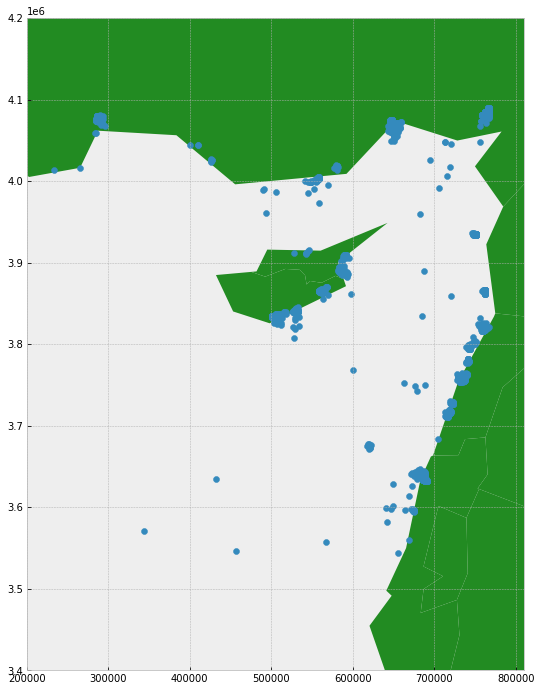

In [21]:
minx, maxx = 200000, 810000
miny, maxy = 3400000, 4200000

plt.figure(figsize=(12,12))
aoi.plot(color="forestgreen", ax=plt.gca())
locations_israel.plot(ax=plt.gca())

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

In [22]:
THR = 10000

In [23]:
locs = locations_israel.copy()
locs["component"] = -1
locs["cell_x"] = (locs["easting"] / THR).astype(int)
locs["cell_y"] = (locs["northing"] / THR).astype(int)

In [24]:
locs.head()

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y
725,687374.333748,3.638761e+06,36,S,POINT (687374.334 3638760.629),-1,68,363
730,690302.316735,3.632251e+06,36,S,POINT (690302.317 3632250.844),-1,69,363
1024,646438.453401,4.073240e+06,36,S,POINT (646438.453 4073240.365),-1,64,407
1026,688454.788028,3.633349e+06,36,S,POINT (688454.788 3633349.143),-1,68,363
1027,501817.238852,3.833990e+06,36,S,POINT (501817.239 3833990.063),-1,50,383


## Convenience routines

In [103]:
a.difference(set([2]))

{1, 3}

In [110]:
a.update(pd.Index([6,7,8]))

In [111]:
a

{1, 2, 3, 4, 5, 6, 7, 8}

In [133]:
def get_in_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""
    return np.sqrt(np.square(locs[["easting", "northing"]] - loc[["easting", "northing"]]).sum(axis=1))


def get_in_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""

    cand_mask_x = (locs.cell_x==loc.cell_x) | (locs.cell_x==(loc.cell_x-1)) | (locs.cell_x==(loc.cell_x+1))
    cand_mask_y = (locs.cell_y==loc.cell_y) | (locs.cell_y==(loc.cell_y-1)) | (locs.cell_y==(loc.cell_y+1))
    cand_mask = cand_mask_x & cand_mask_y & (locs.component==-1)
    candidates = locs[cand_mask]

    dist = get_in_zone_distances(loc, candidates)
    return candidates[dist<=thr]


def get_cross_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""
    return locs.iloc[:0]


class ConnectedComponent(object):
    """Connected component entity. New elements can be added, and component can check if it's finished."""
    def __init__(self, cid, all_locations, thr):
        self.members = set()
        self.visited = set()
        self.cid = cid
        self.all_locations = all_locations
        self.thr = thr

    def add(self, element):
        self.members.add(element)

    def visit(self, element):
        if element not in self.members:
            raise ValueError(f"element {element} is not in this component")
        self.visited.add(element)

    def is_full(self):
        return self.members==self.visited

    def grow(self, locs=None):
        """Grow this component by elements from `locs`."""

        subset = self.members.difference(self.visited)
        locs = locs if locs is not None else self.all_locations

        for element in subset:
            neighbors = get_in_zone_neighbors(self.all_locations.loc[element], locs, self.thr)

            if self.all_locations.loc[element, "border"]:
                cross_zone_neighbors = get_cross_zone_neighbors(self.all_locations.loc[element], locs, self.thr)
                neighbors = pd.concat([neighbors, cross_zone_neighbors])

            self.members.update(neighbors.index)
            self.visited.add(element)

    @property
    def elements(self):
        return list(self.members)

    @property
    def size(self):
        return len(self.members)

In [113]:
get_in_zone_distances(locs.iloc[0], locs.iloc[:100])

725          0.000000
730       7137.953964
1024    436403.927248
1026      5518.293329
1027    269343.585913
            ...      
9215      5692.293896
9216      5725.467472
9217      5650.180756
9218      5813.979991
9219      5295.042348
Length: 100, dtype: float64

In [114]:
get_in_zone_neighbors(locs.iloc[0], locs.iloc[:100], THR)

,easting,northing,zone_number,zone_letter,geometry,component,cell_x,cell_y
725,687374.333748,3.638761e+06,36,S,POINT (687374.334 3638760.629),-1,68,363
730,690302.316735,3.632251e+06,36,S,POINT (690302.317 3632250.844),-1,69,363
1026,688454.788028,3.633349e+06,36,S,POINT (688454.788 3633349.143),-1,68,363
1037,688327.372099,3.632662e+06,36,S,POINT (688327.372 3632662.306),-1,68,363
1049,688307.570843,3.632866e+06,36,S,POINT (688307.571 3632866.032),-1,68,363
1061,688485.325713,3.633369e+06,36,S,POINT (688485.326 3633368.582),-1,68,363
1073,688285.321695,3.633198e+06,36,S,POINT (688285.322 3633198.385),-1,68,363
1074,685847.004516,3.636702e+06,36,S,POINT (685847.005 3636701.841),-1,68,363
1090,688498.721303,3.632666e+06,36,S,POINT (688498.721 3632665.569),-1,68,363
6948,686130.489929,3.638551e+06,36,S,POINT (686130.490 3638550.746),-1,68,363


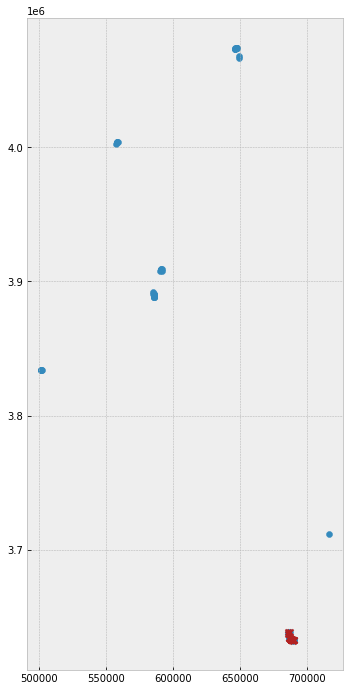

In [115]:
plt.figure(figsize=(12,12))
locs.iloc[:100].plot(ax=plt.gca())
get_in_zone_neighbors(locs.iloc[0], locs.iloc[:100], THR).plot(c="firebrick", ax=plt.gca(), marker="x");

In [116]:
ConnectedComponent?

Init signature: ConnectedComponent(cid, all_locations, thr)
Docstring:      Connected component entity. New elements can be added, and component can check if it's finished.
Type:           type
Subclasses:     


In [117]:
locs["border"] = False

In [118]:
locs.iloc[0]

easting                                      687374.333748
northing                                     3638760.62875
zone_number                                             36
zone_letter                                              S
geometry       POINT (687374.3337478098 3638760.628750423)
component                                               -1
cell_x                                                  68
cell_y                                                 363
border                                               False
Name: 725, dtype: object

In [126]:
c = ConnectedComponent(0, locs, THR)
c.add(725)
c.elements, c.is_full(), c.size

([725], False, 1)

In [127]:
c.visit(725)
c.is_full()

True

In [128]:
c.visit(4)

ValueError: element 4 is not in this component

In [129]:
c.elements, c.is_full(), c.size

([725], True, 1)

In [167]:
c = ConnectedComponent(0, locs, THR)
c.add(725)

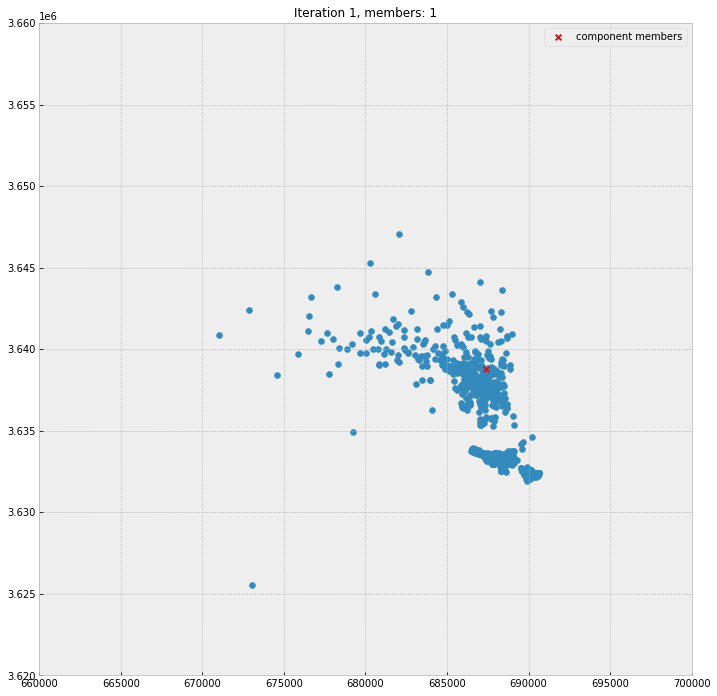

In [172]:
plt.figure(figsize=(12,12))
locs.plot(ax=plt.gca())
locs.loc[c.elements].plot(c="firebrick", ax=plt.gca(), marker="x", markersize=32, label="component members")

plt.legend(loc=0)

plt.xlim(660000, 700000)
plt.ylim(3620000, 3660000)

plt.title(f"Iteration 1, members: {c.size}", fontsize=12);

In [173]:
c.grow(locs)
c.size, c.is_full(), len(c.members.difference(c.visited))

(2125, False, 2124)

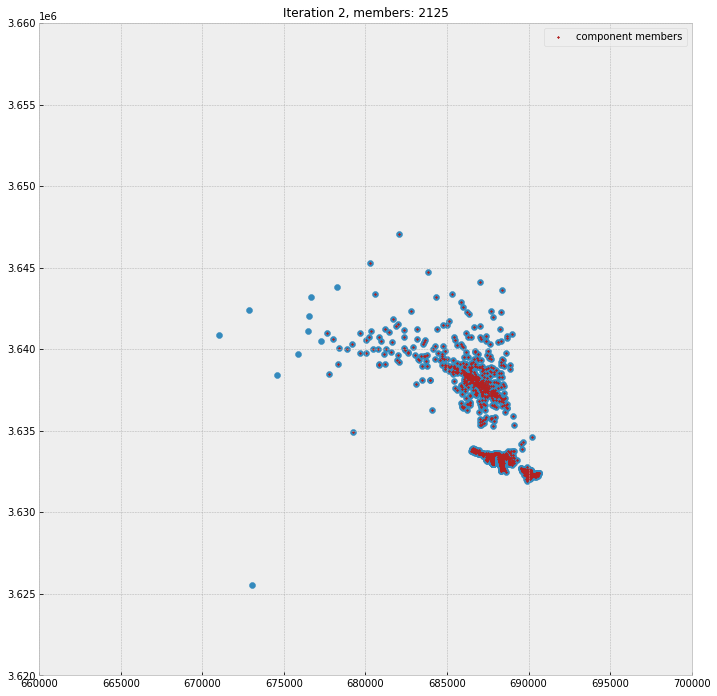

In [174]:
plt.figure(figsize=(12,12))
locs.plot(ax=plt.gca())
locs.loc[c.elements].plot(c="firebrick", ax=plt.gca(), marker="x", markersize=1, label="component members")

plt.legend(loc=0)

plt.xlim(660000, 700000)
plt.ylim(3620000, 3660000)

plt.title(f"Iteration 2, members: {c.size}", fontsize=12);

In [175]:
c.grow(locs)
c.size, c.is_full(), len(c.members.difference(c.visited))

(2134, False, 9)

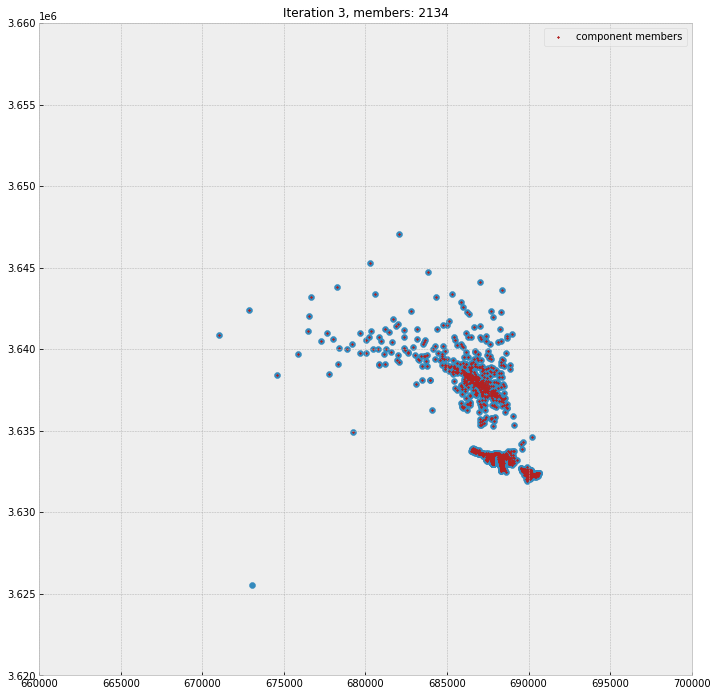

In [176]:
plt.figure(figsize=(12,12))
locs.plot(ax=plt.gca())
locs.loc[c.elements].plot(c="firebrick", ax=plt.gca(), marker="x", markersize=1, label="component members")

plt.legend(loc=0)

plt.xlim(660000, 700000)
plt.ylim(3620000, 3660000)

plt.title(f"Iteration 3, members: {c.size}", fontsize=12);

In [177]:
c.grow(locs)
c.size, c.is_full(), c.members.difference(c.visited)

(2134, True, set())

In [203]:
locs["component"] = -1
current_cid = -1
components = {}

while (locs.component==-1).sum()!=0:
    current_cid += 1
    seed = locs[locs.component==-1].sample(1).index[0]

    component = ConnectedComponent(current_cid, locs, THR)
    component.add(seed)

    print(f"Starting new component {component.cid}")

    while not component.is_full():
        component.grow(locs)
        print(f"\tGrowing {component.cid}: {component.size}")

    locs.loc[component.elements, "component"] = current_cid
    components[component.cid] = component.elements

Starting new component 0
	Growing 0: 2120
	Growing 0: 2134
	Growing 0: 2134
Starting new component 1
	Growing 1: 884
	Growing 1: 885
	Growing 1: 885
Starting new component 2
	Growing 2: 56
	Growing 2: 63
	Growing 2: 63
Starting new component 3
	Growing 3: 123
	Growing 3: 156
	Growing 3: 160
	Growing 3: 160
Starting new component 4
	Growing 4: 23
	Growing 4: 23
Starting new component 5
	Growing 5: 365
	Growing 5: 368
	Growing 5: 368
Starting new component 6
	Growing 6: 2156
	Growing 6: 2293
	Growing 6: 2297
	Growing 6: 2297
Starting new component 7
	Growing 7: 697
	Growing 7: 711
	Growing 7: 723
	Growing 7: 999
	Growing 7: 1001
	Growing 7: 1002
	Growing 7: 1002
Starting new component 8
	Growing 8: 450
	Growing 8: 451
	Growing 8: 451
Starting new component 9
	Growing 9: 7
	Growing 9: 7
Starting new component 10
	Growing 10: 89
	Growing 10: 100
	Growing 10: 102
	Growing 10: 102
Starting new component 11
	Growing 11: 460
	Growing 11: 469
	Growing 11: 525
	Growing 11: 525
Starting new compo

In [204]:
locs.component.value_counts()

6     2297
0     2134
7     1002
1      885
11     525
8      451
12     436
5      368
14     264
3      160
10     102
13      97
2       63
16      34
30      33
4       23
15      17
9        7
26       7
24       5
34       3
23       3
37       3
19       2
31       2
51       2
27       1
35       1
47       1
39       1
32       1
40       1
48       1
56       1
54       1
46       1
38       1
17       1
22       1
25       1
33       1
53       1
45       1
41       1
29       1
21       1
49       1
57       1
52       1
44       1
36       1
28       1
20       1
18       1
42       1
50       1
43       1
55       1
Name: component, dtype: int64

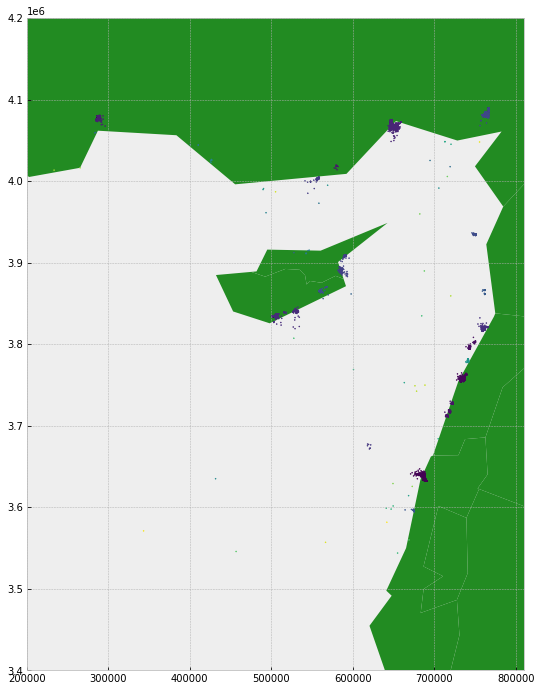

In [207]:
minx, maxx = 200000, 810000
miny, maxy = 3400000, 4200000

plt.figure(figsize=(12,12))
aoi.plot(color="forestgreen", ax=plt.gca())
locs.plot(column="component", ax=plt.gca(), s=1)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy);

(3400000.0, 4200000.0)

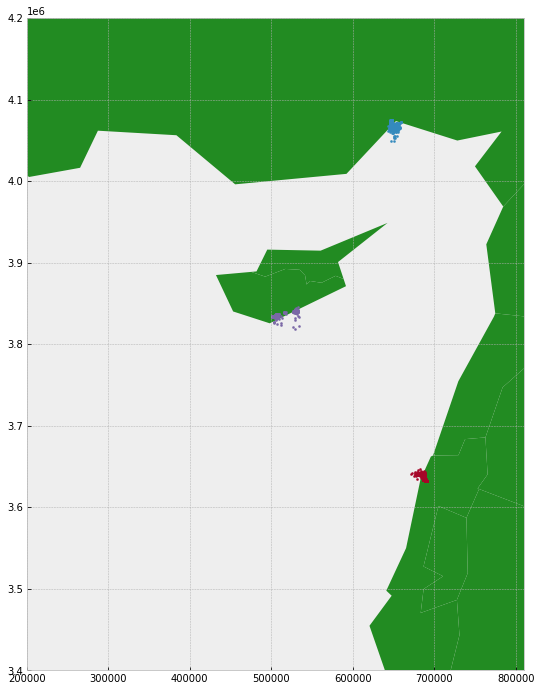

In [208]:
plt.figure(figsize=(12,12))
aoi.plot(color="forestgreen", ax=plt.gca())
locs[locs.component==6].plot(ax=plt.gca(), markersize=4)
locs[locs.component==0].plot(ax=plt.gca(), markersize=4)
locs[locs.component==7].plot(ax=plt.gca(), markersize=4)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

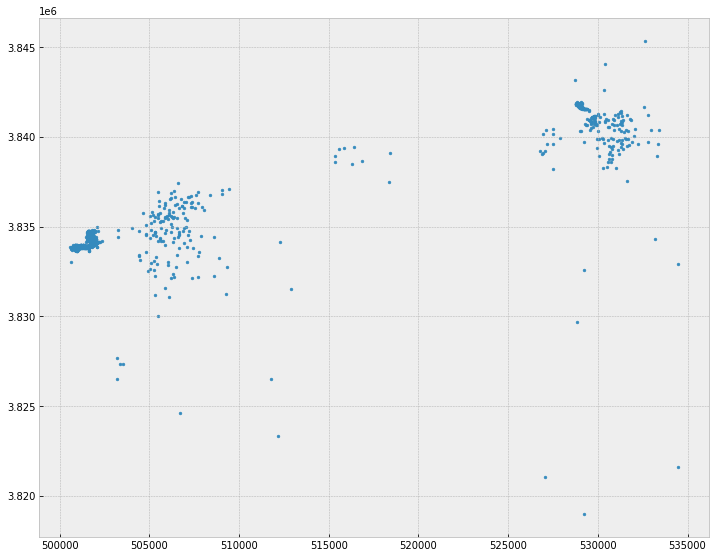

In [211]:
plt.figure(figsize=(12,12))
locs[locs.component==7].plot(ax=plt.gca(), markersize=8)